# Thermodynamic and dynamic contributions

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
import atmotrans as atm

In [2]:
###  seasonal means  ###
time = np.arange(1979,2020)
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/moistdiv_annual_means.nc'
m = xr.open_dataset(f)
mfc = - m['vimd'][:,:-1,:-1] 
mfc_clim = np.nanmean(mfc.values, axis = 0)
f= '../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-monthly-climatology.nc'
climatology = xr.open_dataset(f)
pressure = climatology.level.values
# surface pressure files for each year 
sp_files= glob.glob('../moisture_transport/moisture_transport/cache/srfc-monthly/srfc_pressure_????.nc')
sp_files.sort()
# spacing 
dlat,dlon = atm.get_spacing(climatology.latitude.values, climatology.longitude.values)

### anomalies ###
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/moistdiv_anomalies.nc'
data = xr.open_dataset(f)
mfc_anom = data['vimd'][:,:-1,:-1] 
anomalies = glob.glob('../moisture_transport/moisture_transport/cache/pressure-monthly/*anomaly*.nc')
anomalies.sort()

In [3]:
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'latitude':data.latitude[:-1].values[::-1], 'longitude':data.longitude[:-1].values})
    weights = np.cos(np.deg2rad(data.latitude[:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean

In [7]:
def column_integration(data, sp, qu):
    from scipy import interpolate
    import wrf 
    coords = np.where(sp < 10000)
    pressure = np.zeros((37,201,321))
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]

        pressure[:,ilat,ilon]= data.level.values
        pressure[36, :, :] =  sp
        idx, pl = atm.find_nearest_idx(data.level.values, sp_value)

        # function for extrapolation/ interpolation: 
        x_vals = data.level.values
        y_vals= qu[:,ilat,ilon]
        f = interpolate.interp1d(x_vals, y_vals, fill_value = "extrapolate", kind = 'cubic')

        # set q value below ground to 0 
        if sp_value < 1000:
            if sp_value > pl:
                idx = idx + 1  
            pressure[idx, ilat,ilon] = sp_value
            qu[idx:37, ilat, ilon] =  0

        if sp_value > 1000:
            qu[36, ilat, ilon] = f(sp_value)

    colint = atm.colint_pressure(qu, pressure)

    return colint

In [ ]:
thermodynamic_tp= np.array(())
dynamic_tp = np.array(())
thermodynamic_land= np.array(())
dynamic_land = np.array(())
thermodynamic_con = np.array(())
dynamic_con = np.array(())
thermodynamic_div = np.array(())
dynamic_div = np.array(()) 


# read in files for each year 
for y in np.arange(41): 
    print(anomalies[y])
    # clim values 
    q_c= climatology.q[0].values
    u_c = climatology.u[0].values
    v_c= climatology.v[0].values
    ds = xr.open_dataset(anomalies[y])
    # get annual surface pressure 
    sp = xr.open_dataset(sp_files[y]).sp[0].values / 100
    q_a= ds.q[0].values
    u_a= ds.u[0].values
    v_a= ds.v[0].values
    ds.close()
        
    # product for thermodynamic and dynamic component 
    qc_ua = q_c* u_a 
    qc_va = q_c* v_a
        
    qa_uc = q_a*u_c
    qa_vc = q_a*v_c

    # column-integration   
    dyna_u = column_integration(climatology, sp, qc_ua)
    dyna_v = column_integration(climatology, sp, qc_va)
    thermo_u = column_integration(climatology, sp, qa_uc)
    thermo_v = column_integration(climatology, sp, qa_vc)
    
    # divergence 
    thermo= atm.divergence(climatology,thermo_u, thermo_v)
    dyna = atm.divergence(climatology, dyna_u, dyna_v)

    # calculate regional averages and append to timeseries 
    th_tp, th_land, th_con, th_div =  mask_region(thermo)
    dy_tp, dy_land, dy_con, dy_div  =  mask_region(dyna)
    
    # append to annual timeseries 
    thermodynamic_tp = np.append(thermodynamic,dy_tp)
    dynamic_tp = np.append(dynamic,dy_tp)
    
    thermodynamic_land = np.append(thermodynamic,th_land)
    dynamic_land = np.append(dynamic,dy_land)
    
    thermodynamic_con = np.append(thermodynamic,th_con)
    dynamic_con = np.append(dynamic,dy_con)
    
    thermodynamic_div = np.append(thermodynamic,th_div)
    dynamic_div = np.append(dynamic,dy_div)


../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1979.nc


In [57]:
mfc_anomalies = np.zeros((41,))
for t in np.arange(41):
    mfc_anomalies[t] = atm.weighted_mean(mfc_anom[t], climatology)

In [108]:
f= '../moisture_transport/moisture_transport/cache/timeseries/moistdiv_timeseries.nc'
m = xr.open_dataset(f)
moistdiv = -m['vimd'].values[:,0,0]

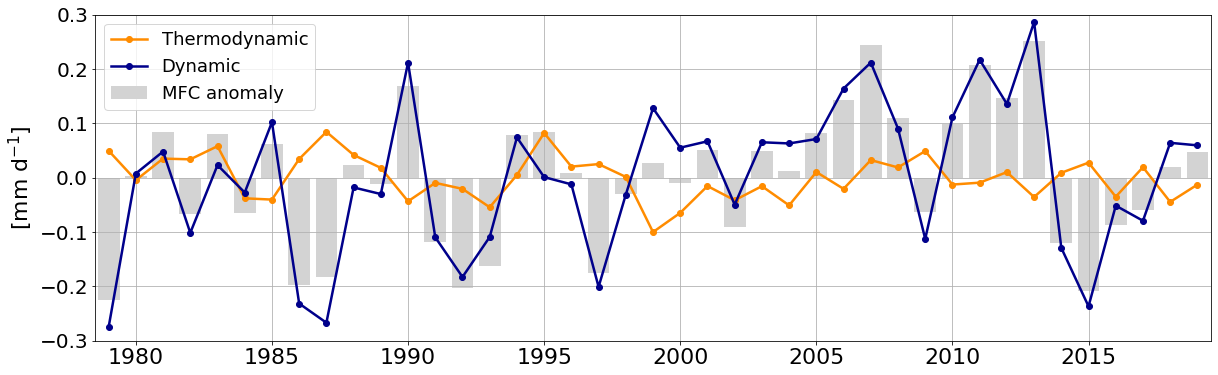

In [48]:
plt.figure(figsize= (20,6))
s= 22

plt.plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
plt.plot(time, dynamic, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
plt.bar(time, dynamic + thermodynamic , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
plt.ylim(-0.3, 0.3)
plt.xlim(time[0]-0.5, time[-1]+0.5)
plt.xticks(time[1::5], time[1::5] , fontsize= 22)
plt.yticks(np.linspace(-0.3, 0.3, 7), fontsize= 20)

plt.ylabel('[mm d$^{-1}$]', fontsize = s)
plt.legend(fontsize= 18)
plt.grid()
plt.savefig('plots/thermodynamic_dynamic_whole_region.png')

In [55]:
# Extract timeseries for specific regions 

def mask_regions(field, mfc_clim ):
    ### TP ###
    dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
    elevation = xr.open_dataset(dem)['elevation']
    elevations_tp= elevation[800:1200, 1840:2480]
    lat = np.linspace(800,1199,200)
    lon= np.linspace(1840,2479,320)
    elevs= elevations_tp.interp(nlat= lat, nlon= lon )
    field_tp= thermo.copy()
    field_tp.values[:,elevs < 3000 ] = np.nan
 
    ### Land ### 
    lm= xr.open_dataset('../moisture_transport/moisture_transport/lsm_era5_tp.nc')['lsm'][0].values
    lsm= np.flip(lm, axis = 0)
    field_land= field.copy()
    field_land.values[:, lsm == 0] = np.nan

    ### convergence zones ###
    field_con= field.copy()
    field_con.values[:, mfc_clim < 0] = np.nan

    ### divergence zones ###
    field_div= field.copy()
    field_div.values[:, mfc_clim > 0] = np.nan

    # area-weighted means timeseries
    mean_tp = weighted_mean(field_tp)
    mean_land = weighted_mean(field_land)
    mean_con = weighted_mean(field_con )
    mean_div = weighted_mean(field_div) 
    
    return mean_tp, mean_land, mean_con, mean_div

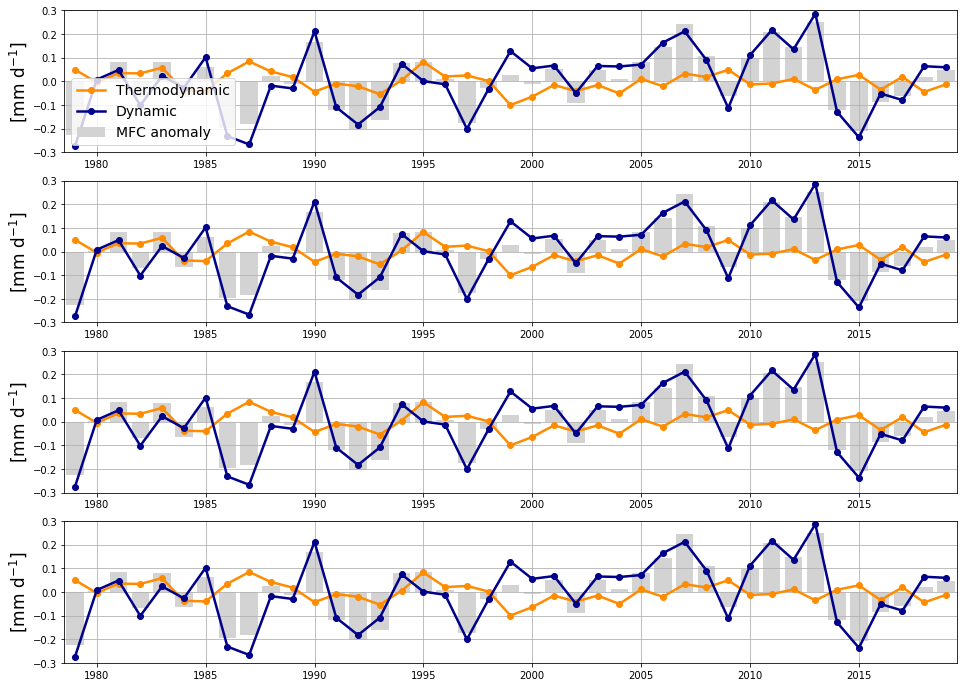

In [53]:
# plot 

s= 17

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(16, 12))

axes[0].plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[0].plot(time, dynamic, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[0].bar(time, dynamic + thermodynamic , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[0].set_ylim(-0.3, 0.3)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_xticks(time[1::5])
axes[0].set_yticks(np.linspace(-0.3, 0.3, 7))
axes[0].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[0].legend(fontsize= 14)
axes[0].grid()



axes[1].plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[1].plot(time, dynamic, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[1].bar(time, dynamic + thermodynamic , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[1].set_ylim(-0.3, 0.3)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_xticks(time[1::5])
axes[1].set_yticks(np.linspace(-0.3, 0.3, 7))
axes[1].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[1].grid()

axes[2].plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[2].plot(time, dynamic, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[2].bar(time, dynamic + thermodynamic , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[2].set_ylim(-0.3, 0.3)
axes[2].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[2].set_xticks(time[1::5])
axes[2].set_yticks(np.linspace(-0.3, 0.3, 7))
axes[2].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[2].grid()

axes[3].plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[3].plot(time, dynamic, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[3].bar(time, dynamic + thermodynamic , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[3].set_ylim(-0.3, 0.3)
axes[3].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[3].set_xticks(time[1::5] )
axes[3].set_yticks(np.linspace(-0.3, 0.3, 7))
axes[3].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[3].grid()

plt.show()